# Starbucks Capstone Challenge

## Introduction
The datasets contain simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). The project represents a one-month experiment for Starbucks to test out the market and see what offers really excite different demographics of people.

## Project Motivation
The purpose of this project is to determine which demographic groups respond best to which offer types, to help Starbucks make better decisions on sending out offers to targeted customers to increase sales and potentially save money.

By sending offers to the RIGHT customers:
- Starbucks can boost brand recognition, customer loyalty, increase sales activities, promote a new product, etc.

By NOT sending offers to the RIGHT customers:
- Starbucks can save costs on the promotion event on customers who would make purchases without offers
- Starbucks can prevent customers from reacting negatively to an offer by not sending the offer

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, r2_score, plot_roc_curve
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
plt.style.use('seaborn-dark')

In [2]:
# read in the cleaned datasets
offers = pd.read_csv('cleaned_data/offers.csv')
customers = pd.read_csv('cleaned_data/customers.csv',parse_dates=['became_member_on'])
events = pd.read_csv('cleaned_data/events.csv')
print(f'offers has {len(offers)} rows')
print(f'customers has {len(customers)} rows')
print(f'events has {len(events)} rows')

offers has 10 rows
customers has 16994 rows
events has 306514 rows


# Data Understanding
### Offers
- id - offer id
- offer_type - type of offer ie BOGO, discount, informational
- offer - **offer type + minimum spend + expiration days + reward + channels**
- For example, bogo_10_7_10_email_mobile_social means a BOGO offer with 10 dollars minimum spend, 7 days to expire, 10 dollars in reward, distributed through email, mobile and social

In [3]:
offers

,offer_type,id,offer
0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo_10_7_10_email_mobile_social
1,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo_10_5_10_web_email_mobile_social
2,informational,3f207df678b143eea3cee63160fa8bed,informational_0_4_0_web_email_mobile
3,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo_5_7_5_web_email_mobile
4,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount_20_10_5_web_email
5,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,discount_7_7_3_web_email_mobile_social
6,discount,fafdcd668e3743c1bb461111dcafc2a4,discount_10_10_2_web_email_mobile_social
7,informational,5a8bc65990b245e5a138643cd4eb9837,informational_0_3_0_email_mobile_social
8,bogo,f19421c1d4aa40978ebb69ca19b0e20d,bogo_5_5_5_web_email_mobile_social
9,discount,2906b810c7d4411798c6938adc9daaa5,discount_10_7_2_web_email_mobile


### Customers
- id - customer id
- gender - customer gender
- age - customer age
- income - customer income
- became_member_on - when the customer became a member

In [71]:
customers.head()

,gender,age,id,became_member_on,income
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


### Events
- customer_id - customer id
- event - record description (ie transaction, offer received, offer viewed, etc.)
- hour - time in hours since start of test. The data begins at hour=0
- offer_id - offer id
- amount_spent - the amount spent by customer
- reward_received - the reward received by customer

In [73]:
events.head()

,customer_id,event,hour,offer_id,amount_spent,reward_received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


### Segment events data by transactions/offers, informational/discount,bogo offers
- The objective of the project is to predict customer response to offers, informational offers do not lead to any response
- Exclude them to only analyze discount and bogo offers
- Seperate transaction events and offer events, to define customer response based on **offer_events**

In [4]:
# Add offer info into events dataset
events = pd.merge(events, offers, how='left', left_on='offer_id', right_on='id').drop(['id','offer_id'],axis=1)

# Remove informational events out of events data
informational_events = events[events.offer_type == 'informational']
offer_events = events[events.offer_type != 'informational']

# Remove transaction events out of events data and store in offer_events
offer_events = offer_events[offer_events.event != 'transaction']
transaction_events = events[events.event == 'transaction']# Remove informational events out of events data
informational_events = events[events.offer_type == 'informational']
offer_events = events[events.offer_type != 'informational']

# Remove transaction events out of events data and store in offer_events
offer_events = offer_events[offer_events.event != 'transaction']
transaction_events = events[events.event == 'transaction']
offer_events.head()

,customer_id,event,hour,amount_spent,reward_received,offer_type,offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,bogo,bogo_5_7_5_web_email_mobile
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,discount,discount_20_10_5_web_email
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,discount,discount_10_7_2_web_email_mobile
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,discount,discount_10_10_2_web_email_mobile_social
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,bogo,bogo_10_5_10_web_email_mobile_social


# Define Customer Response
**A user can receive an offer, never actually view the offer, and still complete the offer.**  
**As a result, we want to segment all customers into 3 groups:**
- **responded**
    - customers who were influenced by the offer and made a purchase - those who **RECEIVED, VIEWED, AND COMPLETED THE OFFER**
- **not_responded**
    - customers who were not influenced by the offer and didn't make a purchase - those who **RECEIVED, VIEWED, AND NOT COMPLETED THE OFFER**
- **invalid_responded**
    - customers who were not influenced by the offer but did make a purchase - those who **RECEIVED, NOT VIEWED, BUT COMPLETED THE OFFER**

In [5]:
def create_offer_type_funnels(offer_types):

    '''
    create a funnel dataset either offer types - discount offers and bogo offers

    INPUT:
        offer_types - a list of the offer type(s)
    OUTPUT:
        funnel - customer funnel dataset of this given offer
    '''

    # Create funnel
    funnel = offer_events[offer_events.offer_type.isin(offer_types)]
    funnel = funnel.groupby(['customer_id','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()
    funnel = pd.pivot(funnel, index='customer_id', columns='event', values='count')
    funnel.columns = [col.replace(' ', '_') for col in funnel.columns]

    return funnel

- 100% customers in this data received at least 1 offer
- 24.5% customers didn't complete the offer
- 2.4% customers didn't view the offer

In [6]:
customer_funnels = create_offer_type_funnels(['discount','bogo'])
customer_funnels.isnull().mean() * 100

offer_completed    24.539225
offer_received      0.000000
offer_viewed        2.392486
dtype: float64

In [7]:
def create_3_response_groups(funnel):
    '''
    create 3 response groups (responded/not_responded/invalid_responded) based on a customer funnel dataset - it can be funnel data for all offers, or for a specific type of offer

    INPUT:
        funnel - a customer funnel dataset for all offer events, OR for a specific offer type (discount, BOGO)
    OUTPUT:
        responded, not_responded, invalid_responded -  response group datasets
    '''

    # Create 3 response type groups
    responded = funnel.dropna()
    not_responded = funnel[funnel.offer_completed.isnull()]
    invalid_responded = funnel[funnel.offer_completed.notnull() & funnel.offer_viewed.isnull()]

    print(round(len(responded)/len(funnel)*100,2), '% responded')
    print(round(len(not_responded)/len(funnel)*100,2), '% did not respond')
    print(round(len(invalid_responded)/len(funnel)*100,2), '% invaildly responded')

    # Make sure these 3 demographic groups are broken down correctly
    assert len(responded) + len(not_responded) + len(invalid_responded) == len(funnel), '3 demographic groups not broken down correctly'  

    return responded, not_responded, invalid_responded

### customer_funnels dataset represents customer response for all offers
So we know that for all offers:
- 74.4 % customers responded to at least 1 offer
- 24.54 % customers did not respond to any offer
- 1.06 % customers completed all received offers without viewing them

**Later on, the funnel input will be funnels for a specific offer, to analyze each offer individually**

In [8]:
responded, not_responded, invalid_responded = create_3_response_groups(customer_funnels)

74.4 % responded
24.54 % did not respond
1.06 % invaildly responded


In [9]:
# Impute responses into customers data
customers['responded'] = customers.id.isin(responded.index).astype(int)
customers['not_responded'] = customers.id.isin(not_responded.index).astype(int)
customers['invalid_responded'] = customers.id.isin(invalid_responded.index).astype(int)
# customers['response'] = customers[['responded','not_responded','invalid_responded']].idxmax(axis=1)
customers.head()

,gender,age,id,became_member_on,income,responded,not_responded,invalid_responded
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,1,0,0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,1
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,1,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,1,0


# Analyze customer demographic for the 3 response groups
- What is the age, income, and membership length distribution for all 3 response groups?

In [10]:
def plot_compare_3_groups(funnel):

    '''
    plot age/income/membership_days distributions by the 3 response groups

    INPUT:
        funnel - a customer funnel dataset for all offer events, OR for a specific offer type (discount, BOGO)
    OUTPUT:
        None - plot 3 distributions
    '''

    # Define response groups
    responded, not_responded, invalid_responded = create_3_response_groups(funnel)

    # Plot 3 graphs
    plt.figure(figsize=(20,6))

    for i, feature in enumerate(['age','income','membership_years']):
        plt.subplot(1,3,i+1)
        sns.kdeplot(customers[customers.id.isin(responded.index)][feature], shade=True, label='responded');
        sns.kdeplot(customers[customers.id.isin(not_responded.index)][feature], shade=True, label='not responded');
        sns.kdeplot(customers[customers.id.isin(invalid_responded.index)][feature], shade=True, label='invalid responded');
        plt.legend(); plt.title(f'{feature} distribution by response group');
        plt.tight_layout()

In [11]:
# Create new feature - membership_years
most_recent = max(customers.became_member_on)
customers['membership_years'] = customers.became_member_on.apply(lambda x: most_recent - x).dt.days / 365

In [12]:
# Null values in customers data
customers.isnull().mean()

gender               0.127928
age                  0.127928
id                   0.000000
became_member_on     0.000000
income               0.127928
responded            0.000000
not_responded        0.000000
invalid_responded    0.000000
membership_years     0.000000
dtype: float64

In [13]:
# Some customers didn't provide any information regarding age, gender and income
# Remove them from customers dataset and create null_customers to store them
null_customers = customers[customers.isnull().any(axis=1)]
customers = customers.dropna()
print(f'response rate for null_customers: {null_customers.responded.mean()}')
print('Looks like customers who do not provide demographic information has a low response rate')

response rate for null_customers: 0.36016559337626497
Looks like customers who do not provide demographic information has a low response rate


# Demographic Distributions for ALL OFFERS
- In general, 74.4% customers responded to offers, and 1.06% customers invalidly responded to offers
- **not responded customers (orange shade)** are mostly young in age, have low income, and have a short length of membership
- **responded customers (blue shade)** are average in age, average in income, and average in length of membership
- **invalid responded customers (green shade)** are the highest in age, the highest in income, highest in length of membership
- The distributions of membership_days suggest that it is the biggest factor for customer response. It may be because new members don't know how to nevigate around the app and respond to the offers.

74.4 % responded
24.54 % did not respond
1.06 % invaildly responded


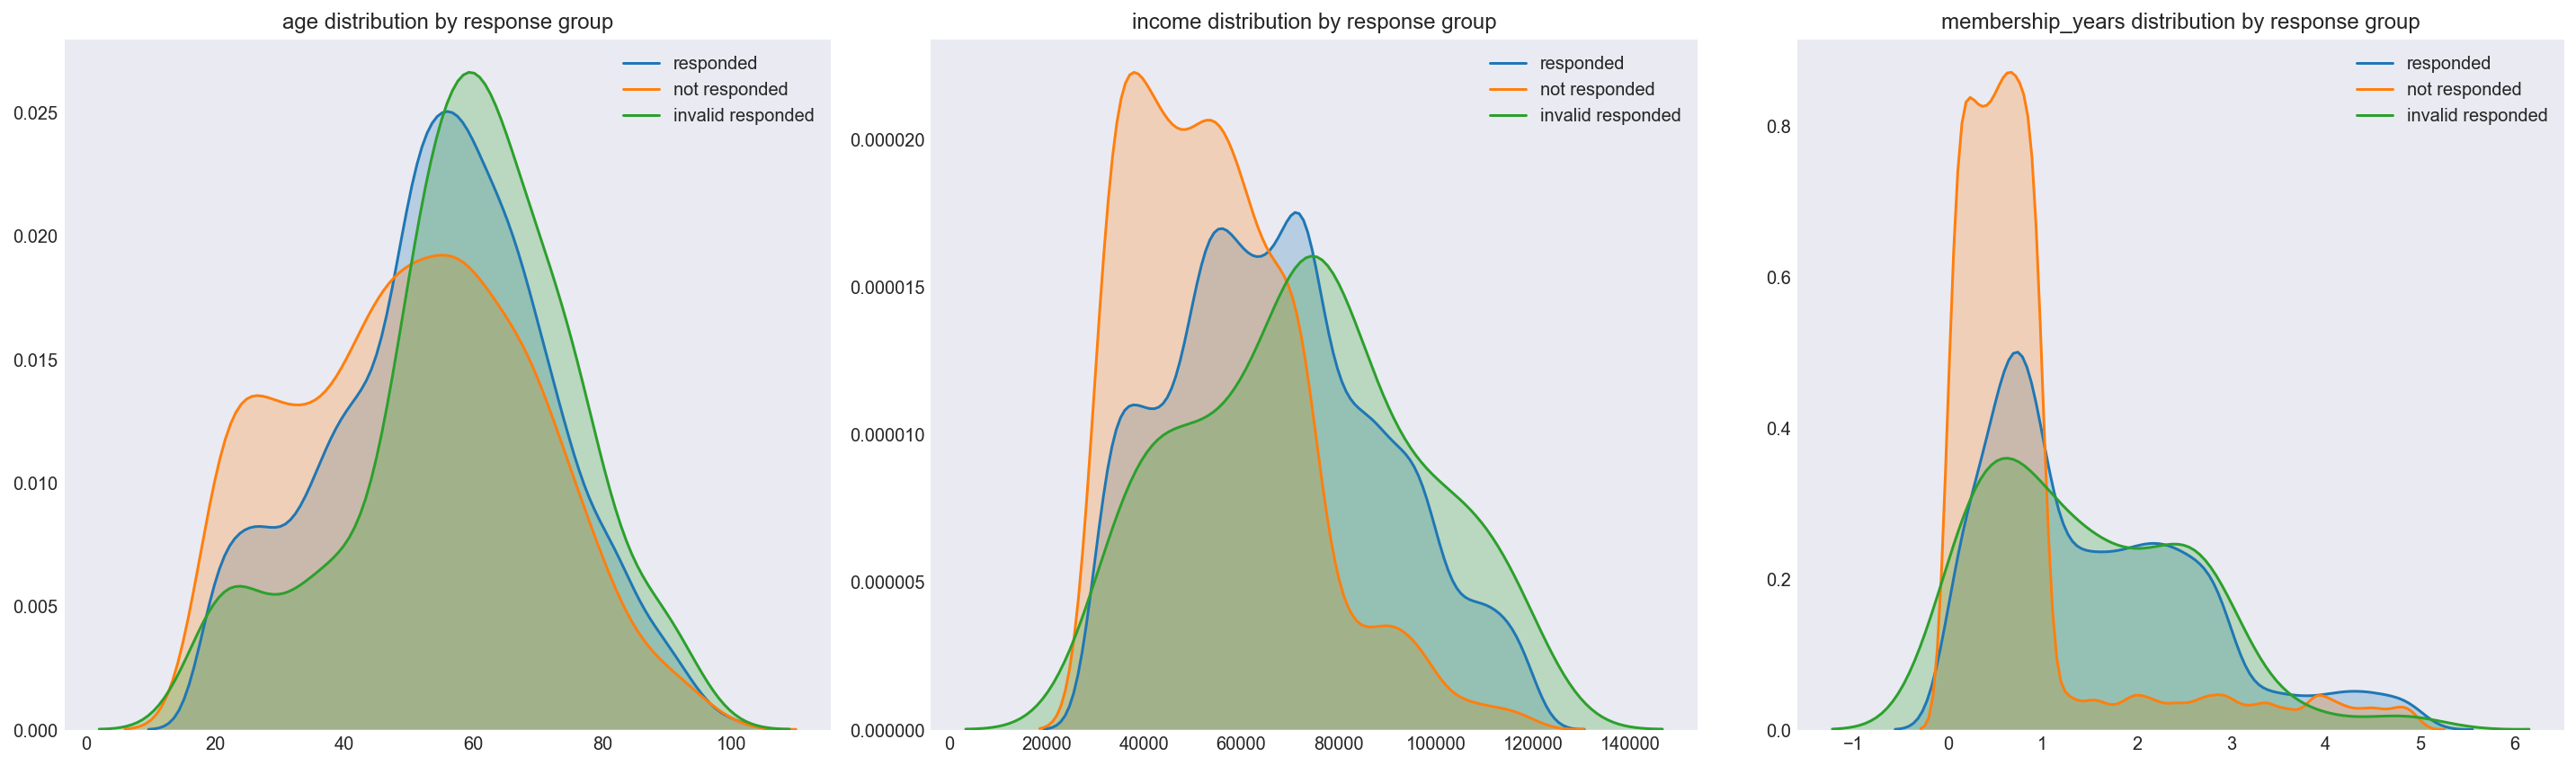

In [93]:
plot_compare_3_groups(customer_funnels)

# Dicount VS BOGO offers

- discount offers seems to have a slightly higher response rate than bogo offers (63% verses 59%)
- The demographics of discount and bogo response groups are quite similar

62.92 % responded
31.15 % did not respond
5.92 % invaildly responded


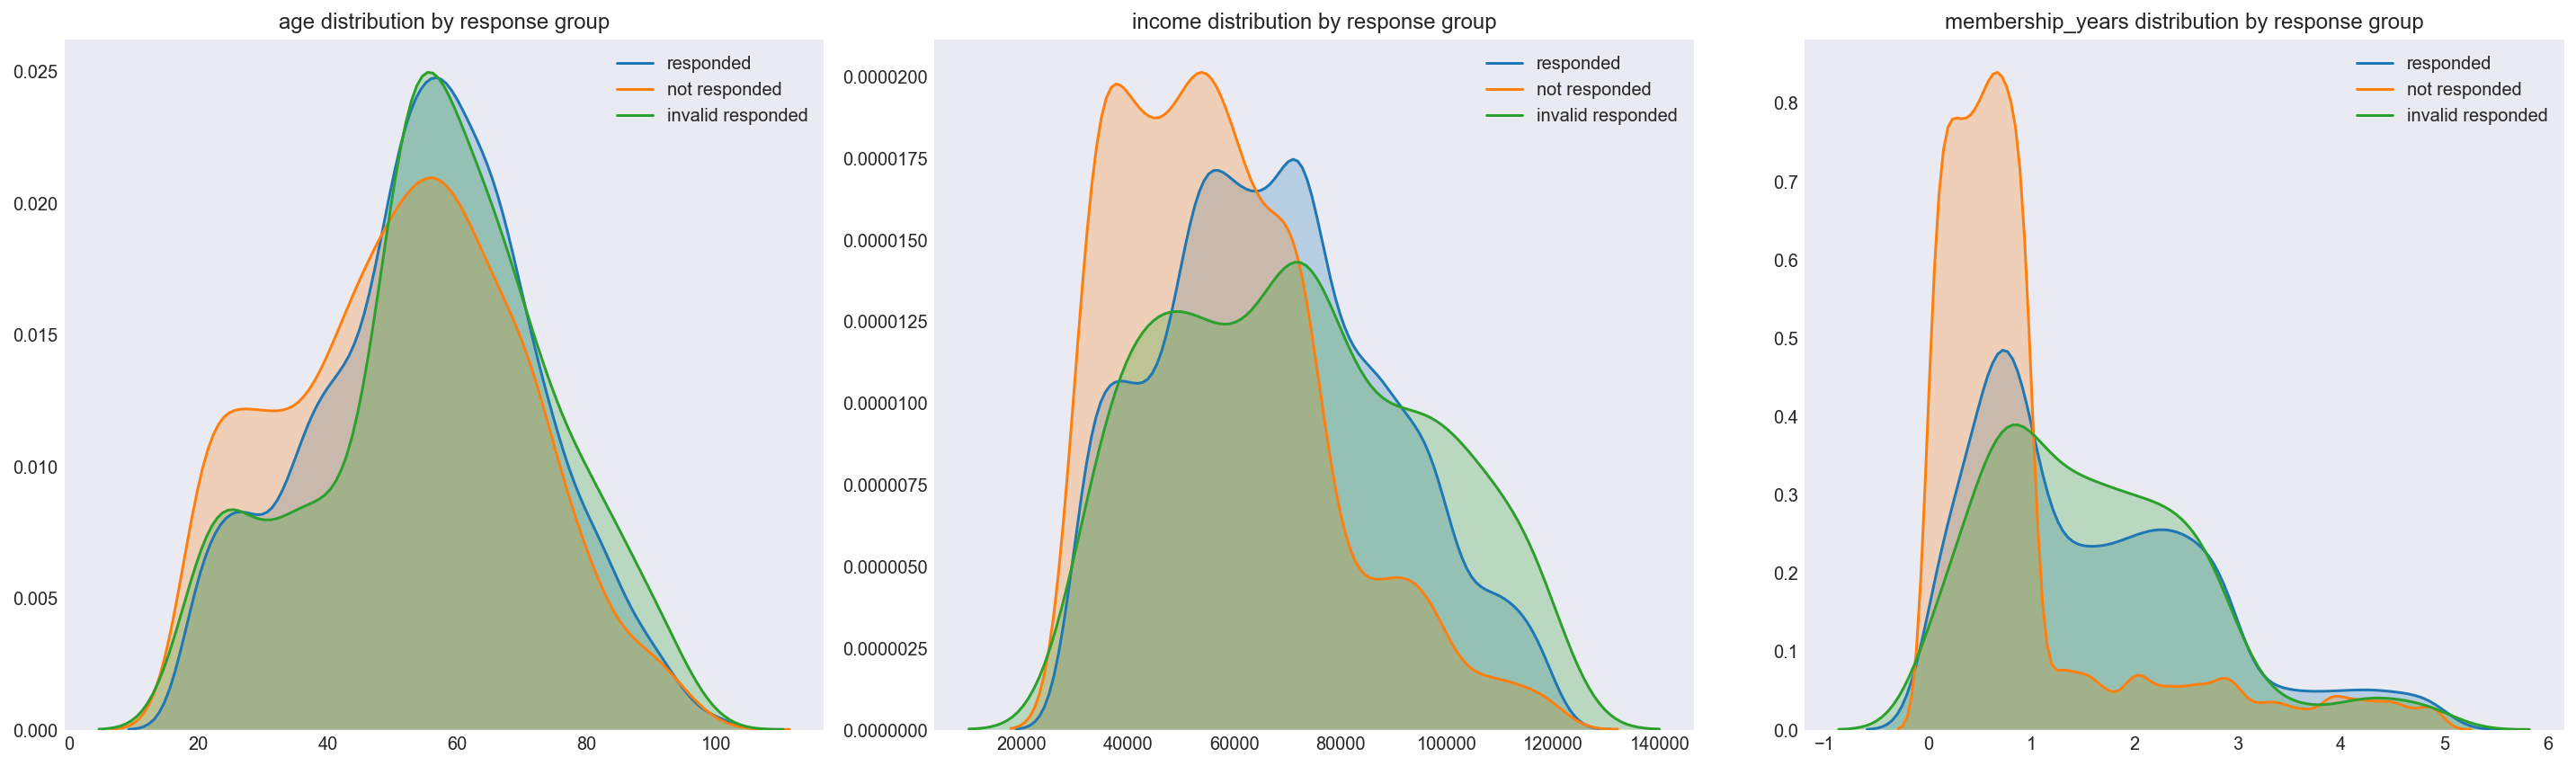

In [95]:
plot_compare_3_groups(create_offer_type_funnels(['discount']))

58.72 % responded
38.21 % did not respond
3.06 % invaildly responded


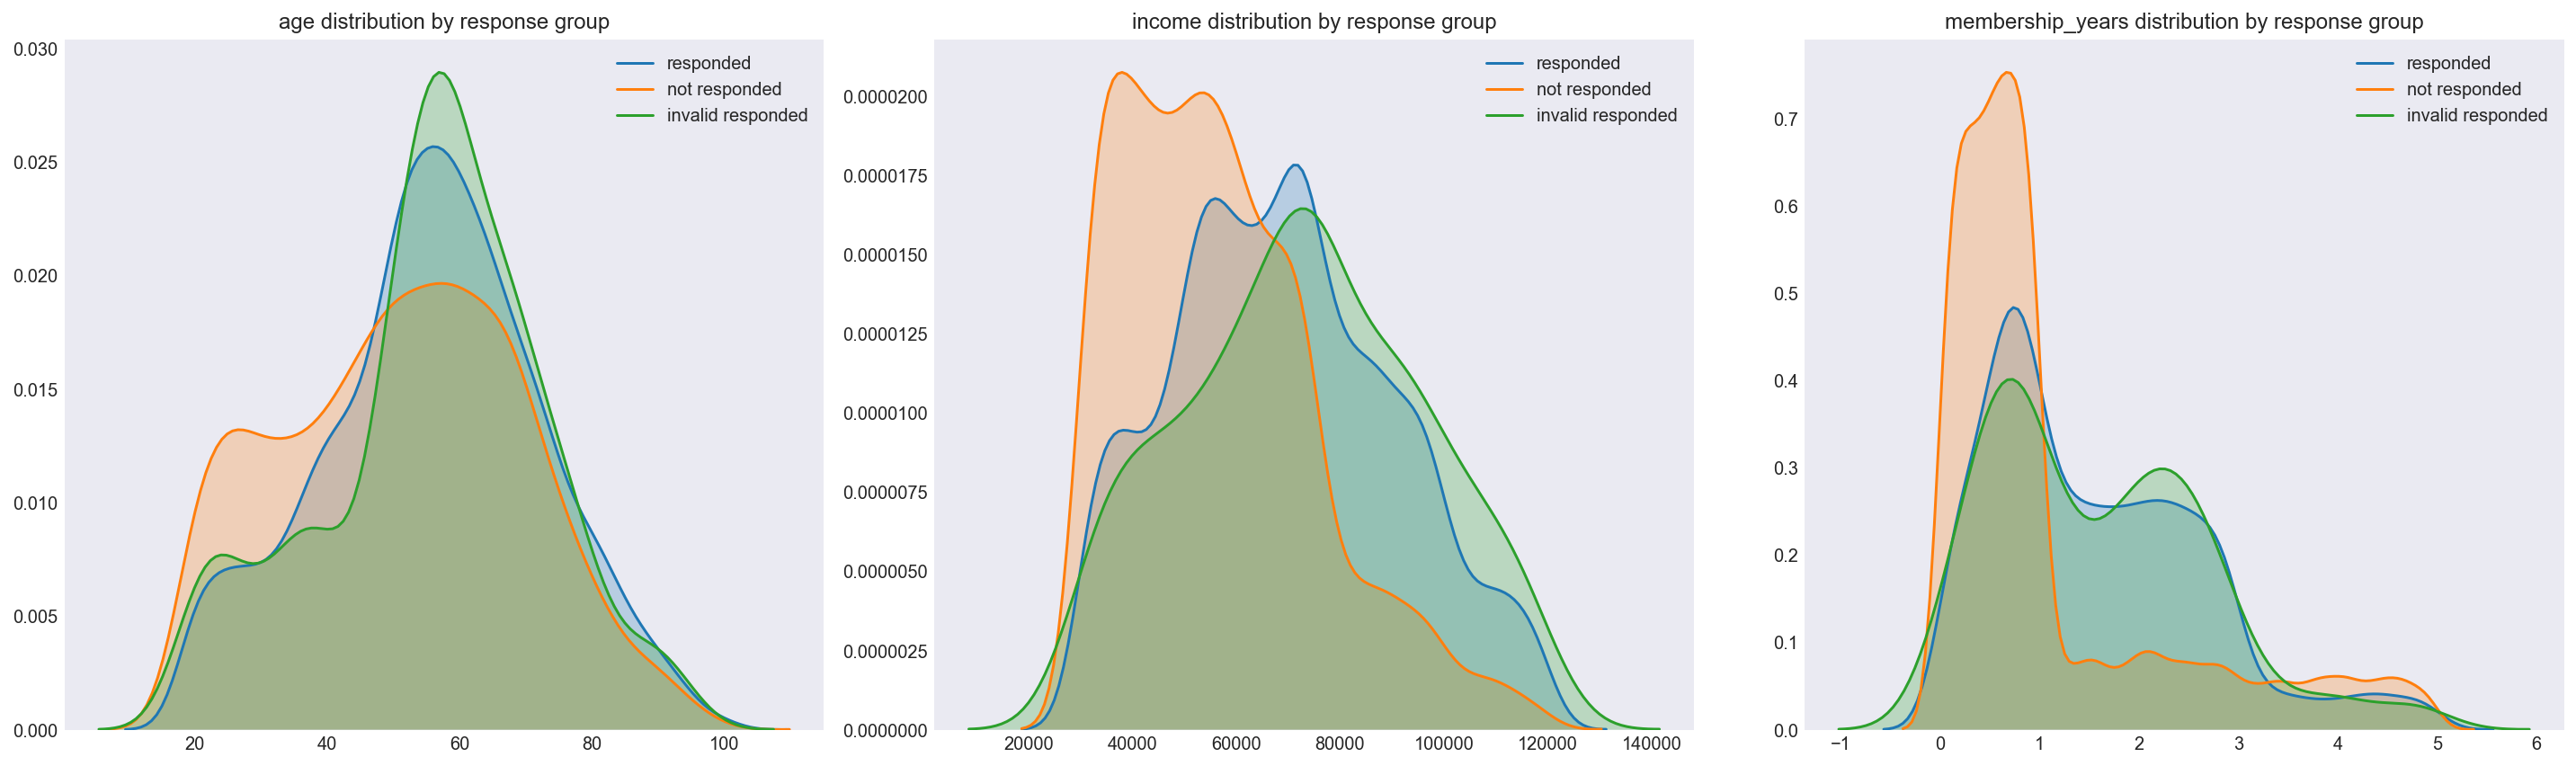

In [96]:
plot_compare_3_groups(create_offer_type_funnels(['bogo']))

# Dig deeper into all 8 offers

In [14]:
def create_offer_funnels(offer):

    '''
    create a funnel dataset by 8 different offer types - discount offers and bogo offers

    INPUT:
        offer - the specific offer type (discount_7_7_3)
    OUTPUT:
        funnel - customer funnel dataset of this given offer
    '''

    # create funnel for the given offer
    funnel = offer_events[offer_events.offer == offer]
    funnel = funnel.groupby(['customer_id','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()
    funnel = pd.pivot(funnel, index='customer_id', columns='event', values='count')
    funnel.columns = [col.replace(' ', '_') for col in funnel.columns]

    return funnel

In [15]:
offer_events.offer.unique()

array(['bogo_5_7_5_web_email_mobile', 'discount_20_10_5_web_email',
       'discount_10_7_2_web_email_mobile',
       'discount_10_10_2_web_email_mobile_social',
       'bogo_10_5_10_web_email_mobile_social',
       'bogo_5_5_5_web_email_mobile_social',
       'discount_7_7_3_web_email_mobile_social',
       'bogo_10_7_10_email_mobile_social'], dtype=object)

# 4 Discount offers
- Note that the offers are broken down into **min_spend, expire_days, reward and channels**

### Insights:
- The discount offer people love the most is discount_10_10_2_web_email_mobile_social, with 70.1% response rate
- The discount offer people love the least is discount_20_10_5_web_email, with 23.09 response rate
- This may be due to the fact that the favorable offer has a lower barrier (10 dollars) whereas the least favorable offer has a high minimum spend (20 dollars)
- Also, with only web and email, the response rate is low; with mobile and social channels, the response rates are significantly higher
- discount_10_7_2_web_email_mobile has a 38% response rate whereas discount_10_10_2_web_email_mobile has a 70.1% response rate, this may suggest that an 10-day expiration period gets much more responses than a 7-day expiration period
- **In conclusion, people respond better to lower minimum spend and longer expiration days with more channels**

23.09 % responded
53.28 % did not respond
23.63 % invaildly responded


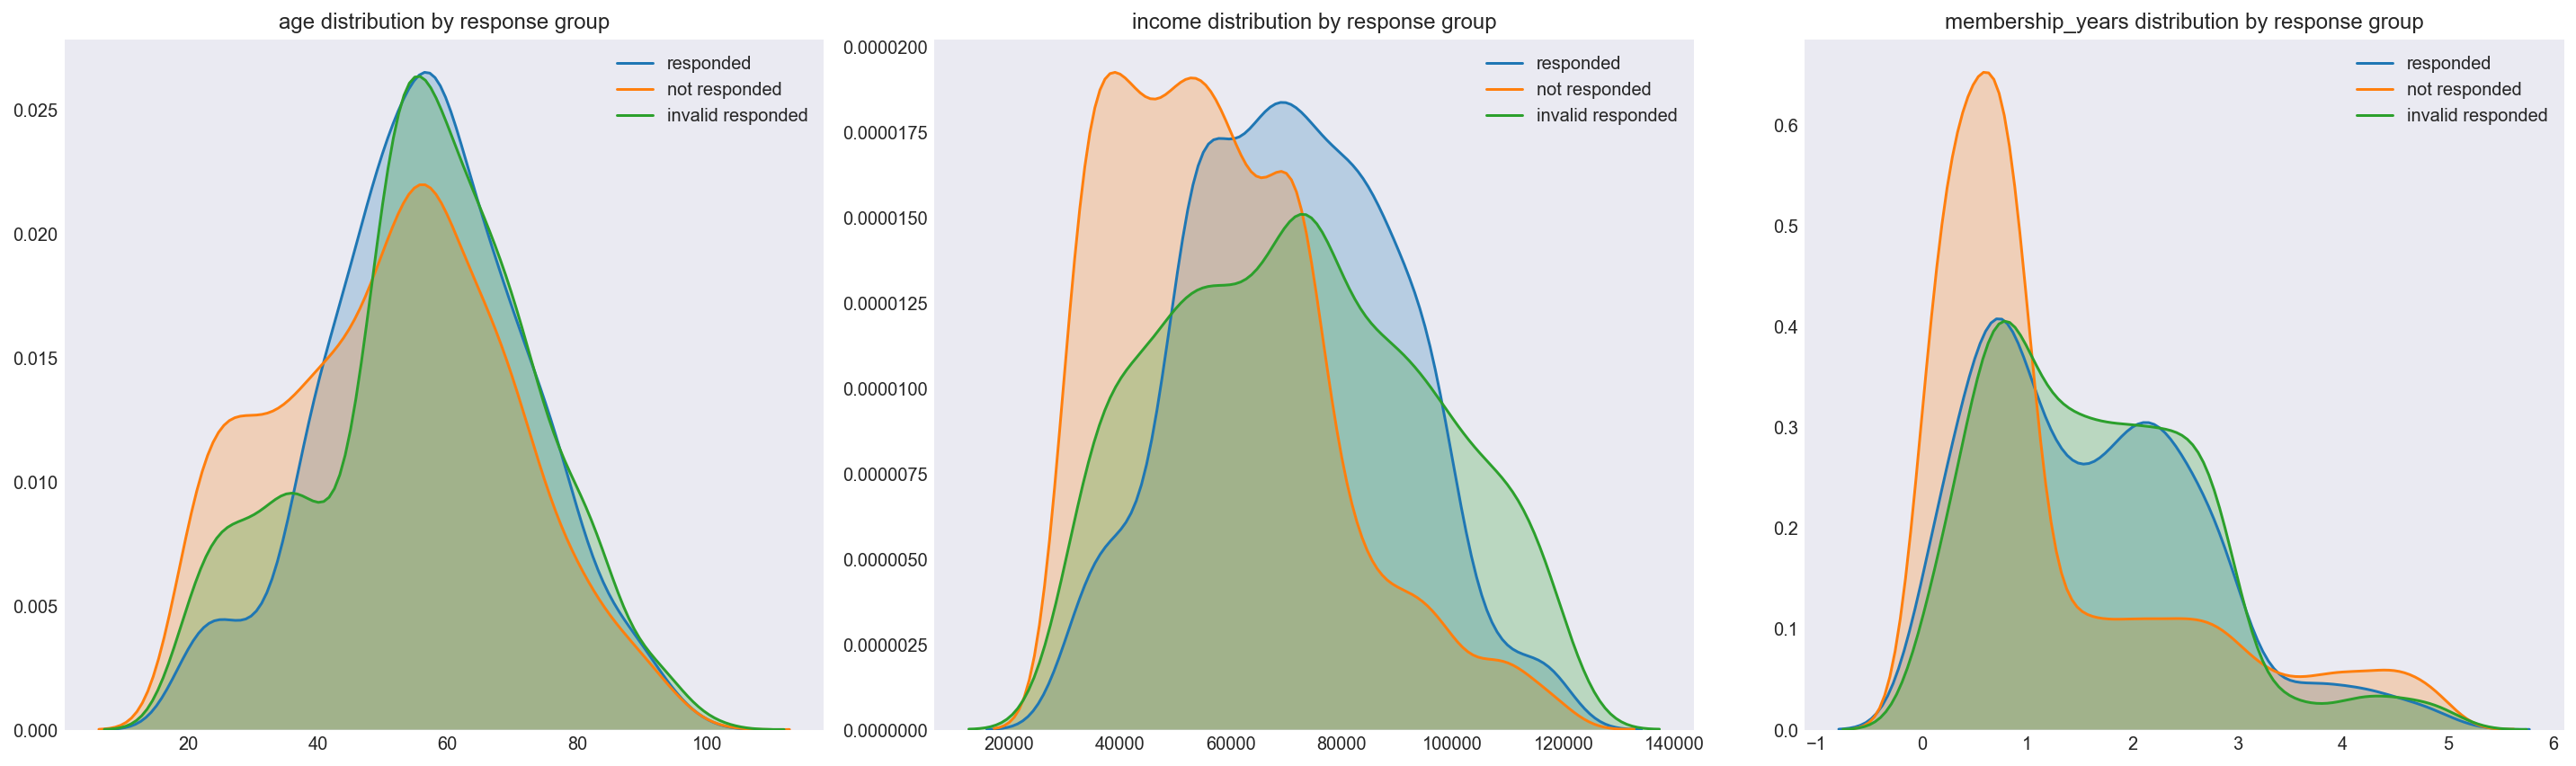

In [103]:
plot_compare_3_groups(create_offer_funnels('discount_20_10_5_web_email'))

38.42 % responded
44.63 % did not respond
16.95 % invaildly responded


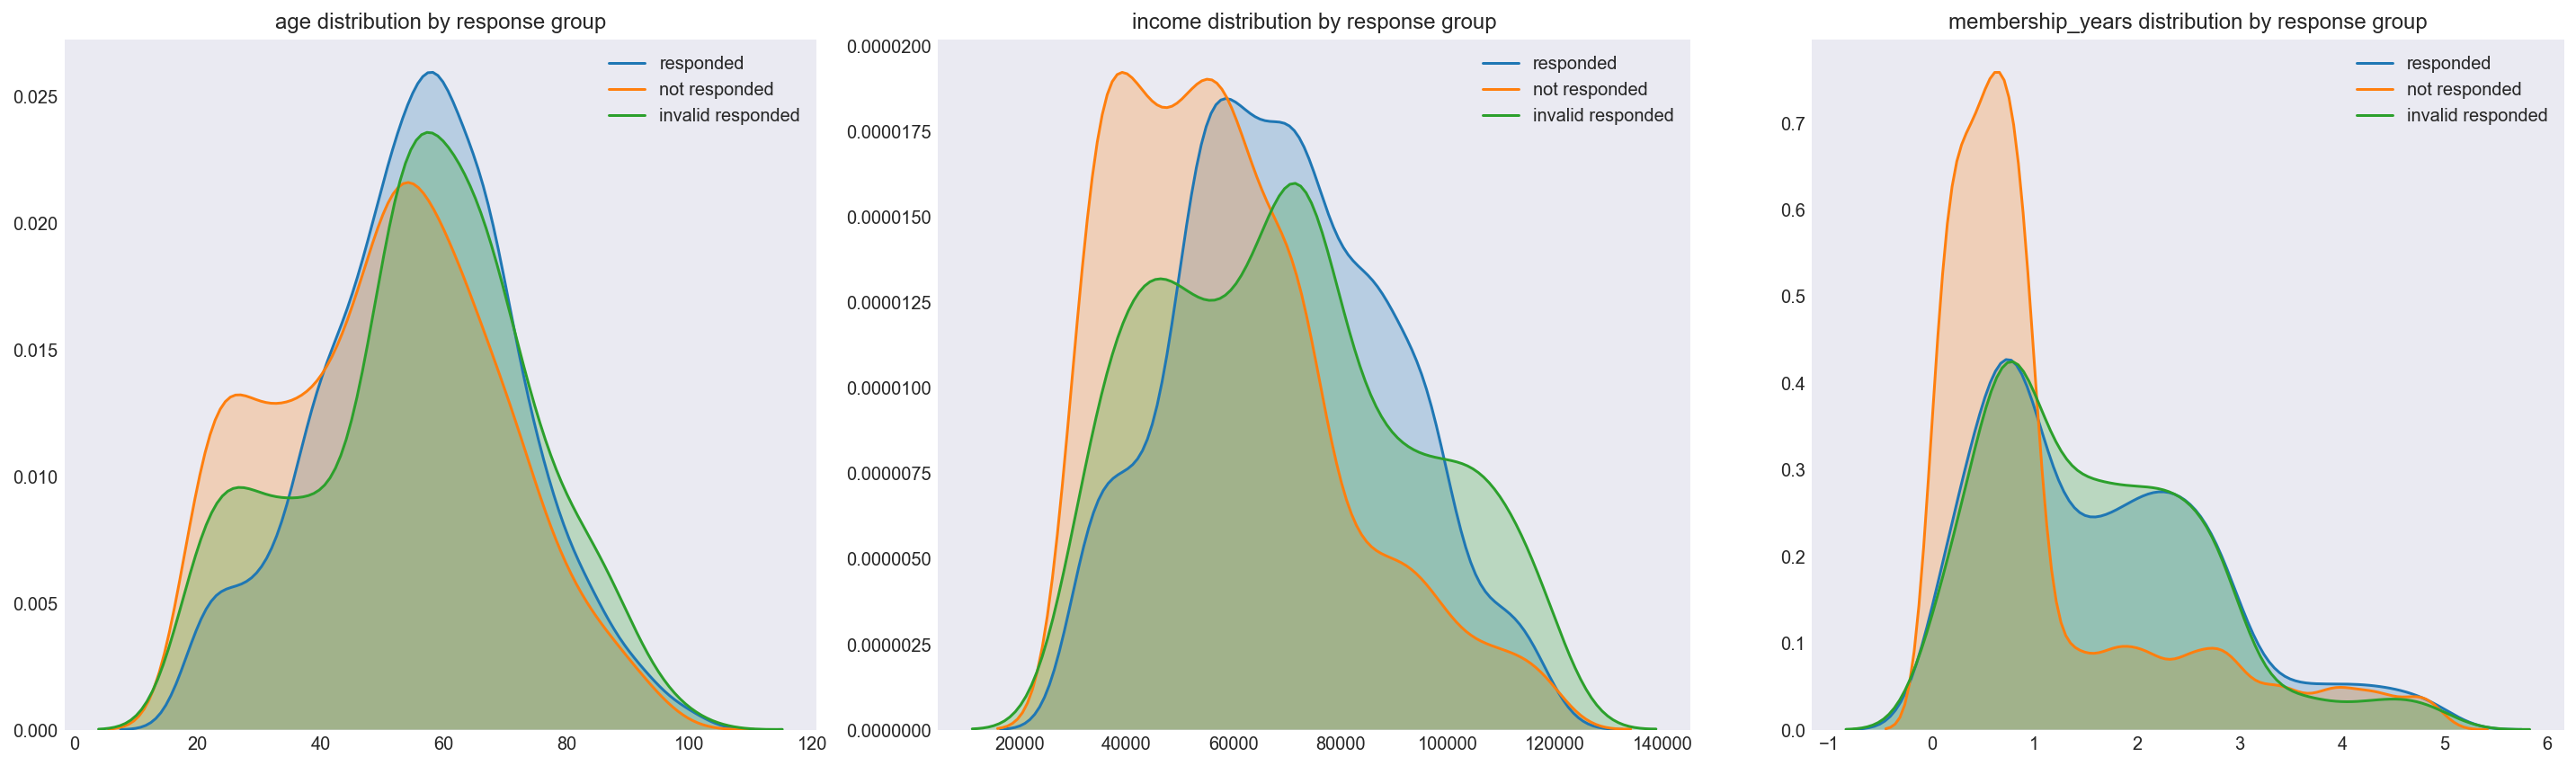

In [104]:
plot_compare_3_groups(create_offer_funnels('discount_10_7_2_web_email_mobile'))

70.01 % responded
28.46 % did not respond
1.53 % invaildly responded


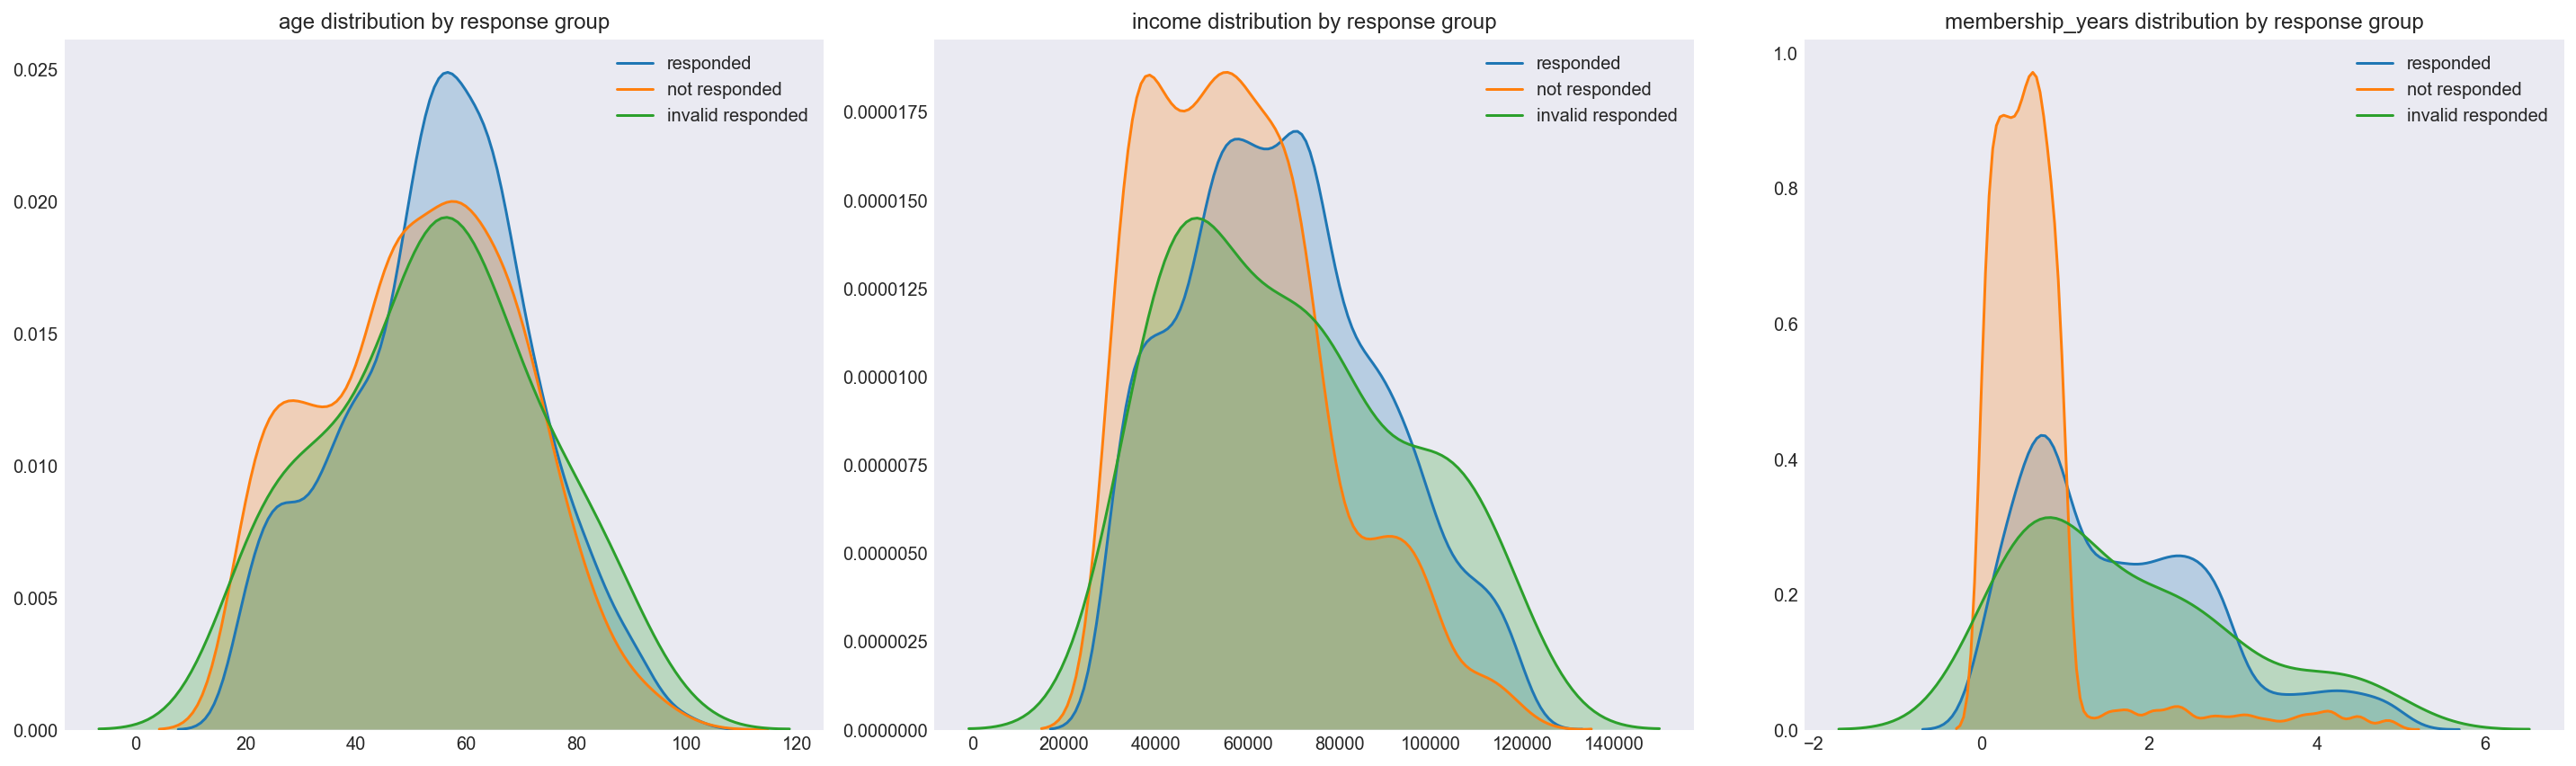

In [105]:
plot_compare_3_groups(create_offer_funnels('discount_10_10_2_web_email_mobile_social'))

68.19 % responded
30.1 % did not respond
1.71 % invaildly responded


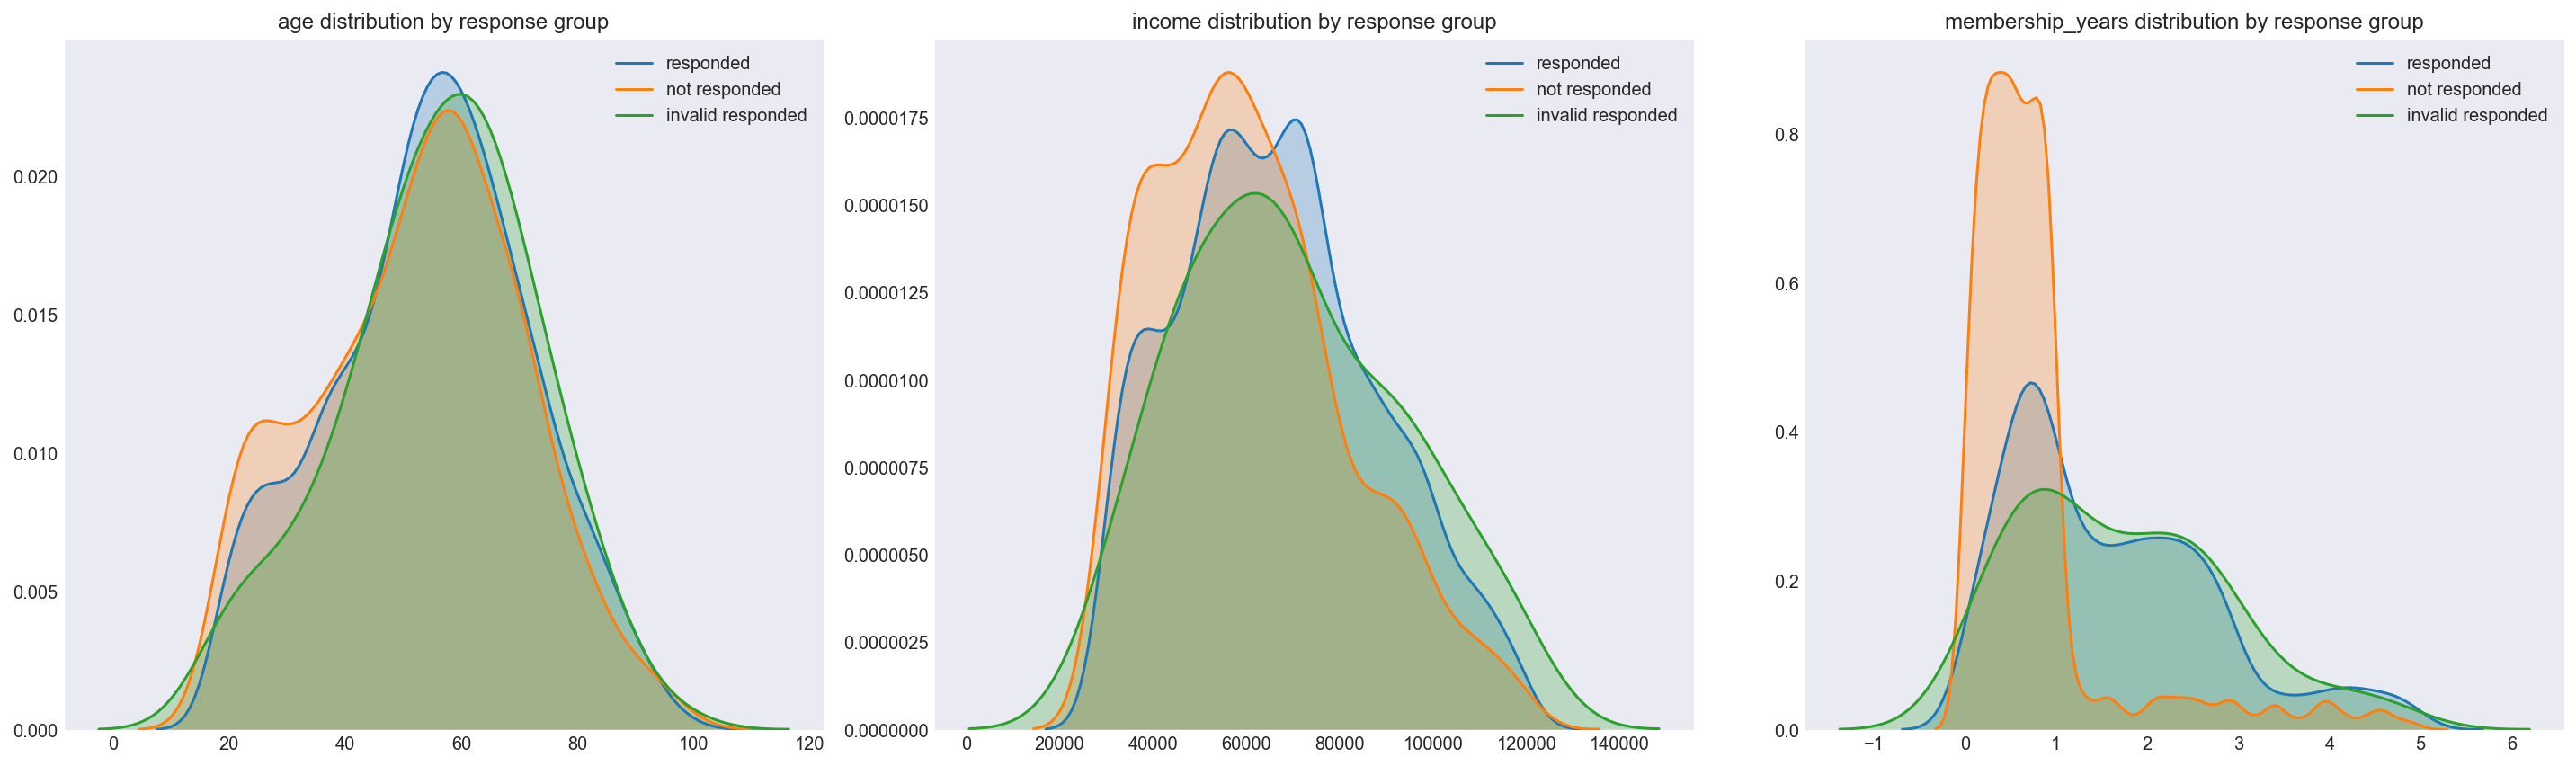

In [106]:
plot_compare_3_groups(create_offer_funnels('discount_7_7_3_web_email_mobile_social'))

# 4 BOGO offers
- The BOGO offer that people love the most is bogo_5_5_5_web_email_mobile_social, with a 58.37% response rate
- The BOGO offer that people love the least is bogo_5_7_5_web_email_mobile, with a 39.4% response rate

### Insights
- In general, the response rates for BOGO is lower than discount offers
- while the two offers above are similar, the most favorable offer has 1 more channel (social) than the least favorable

39.4 % responded
40.46 % did not respond
20.14 % invaildly responded


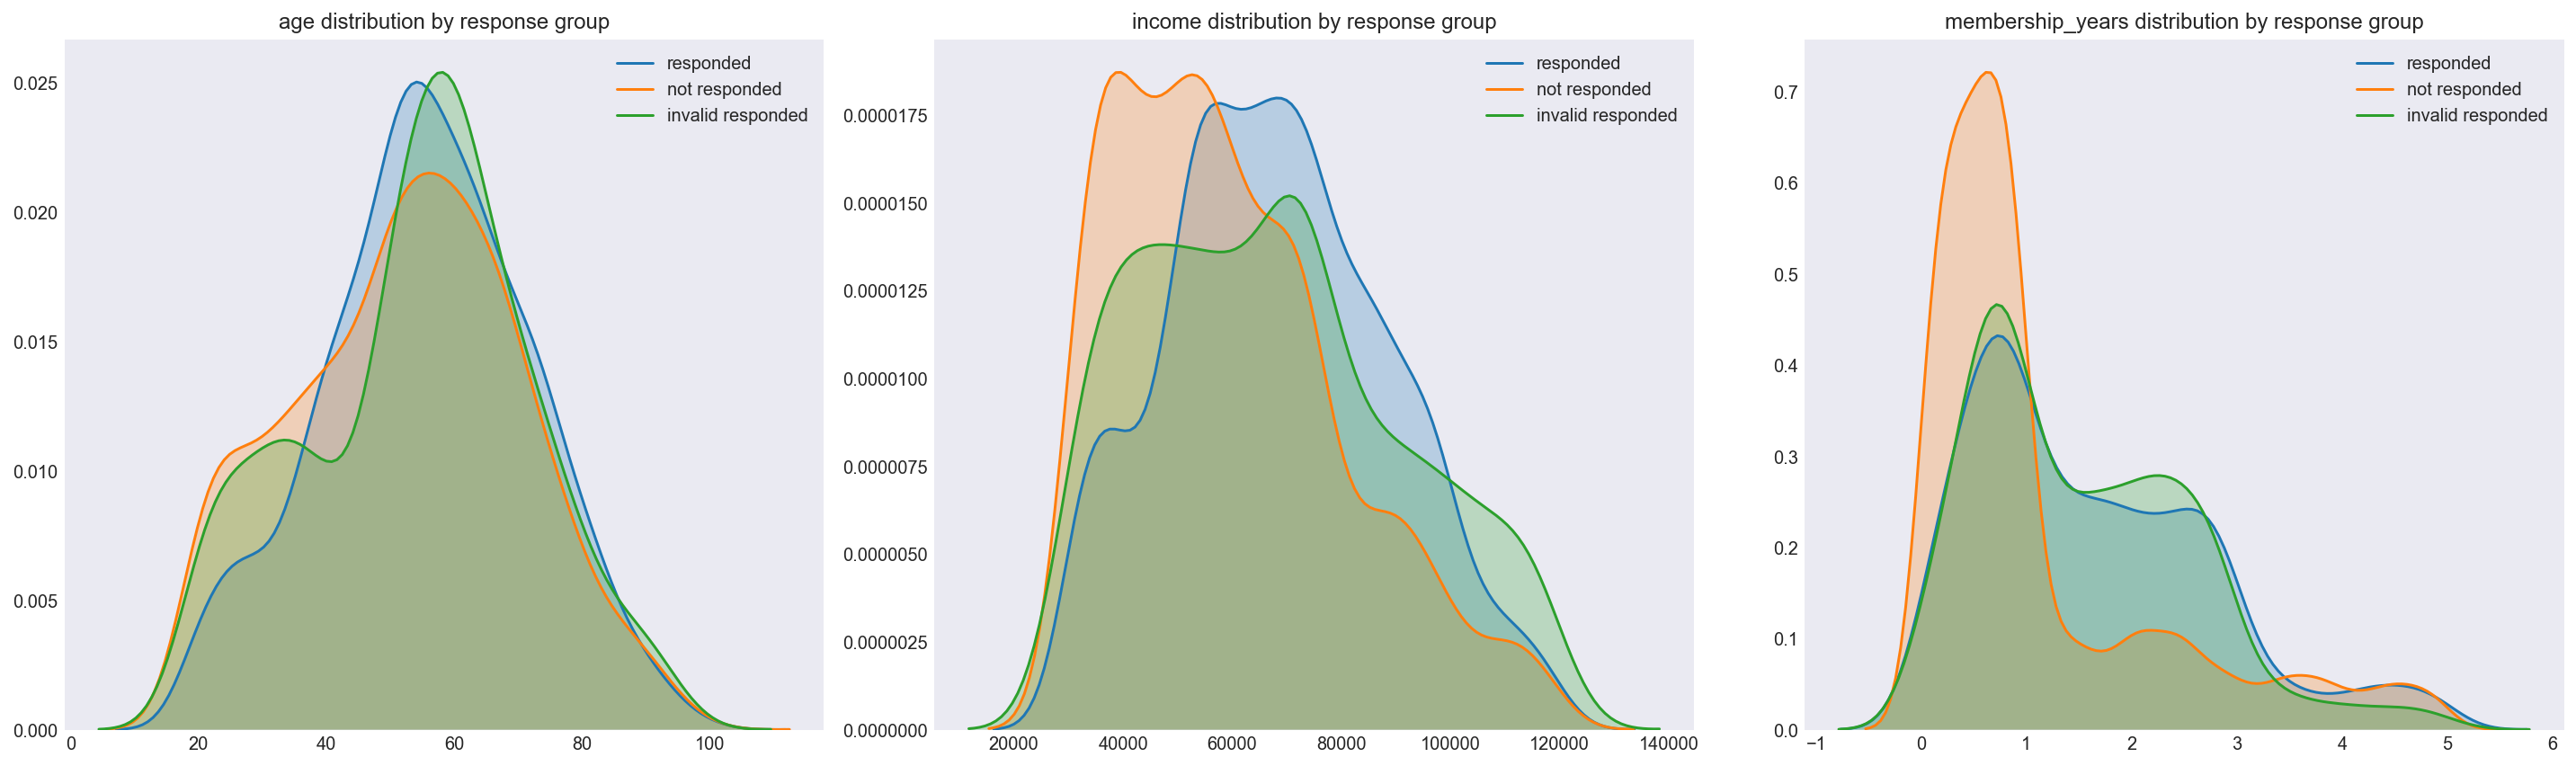

In [108]:
plot_compare_3_groups(create_offer_funnels('bogo_5_7_5_web_email_mobile'))

44.63 % responded
54.42 % did not respond
0.95 % invaildly responded


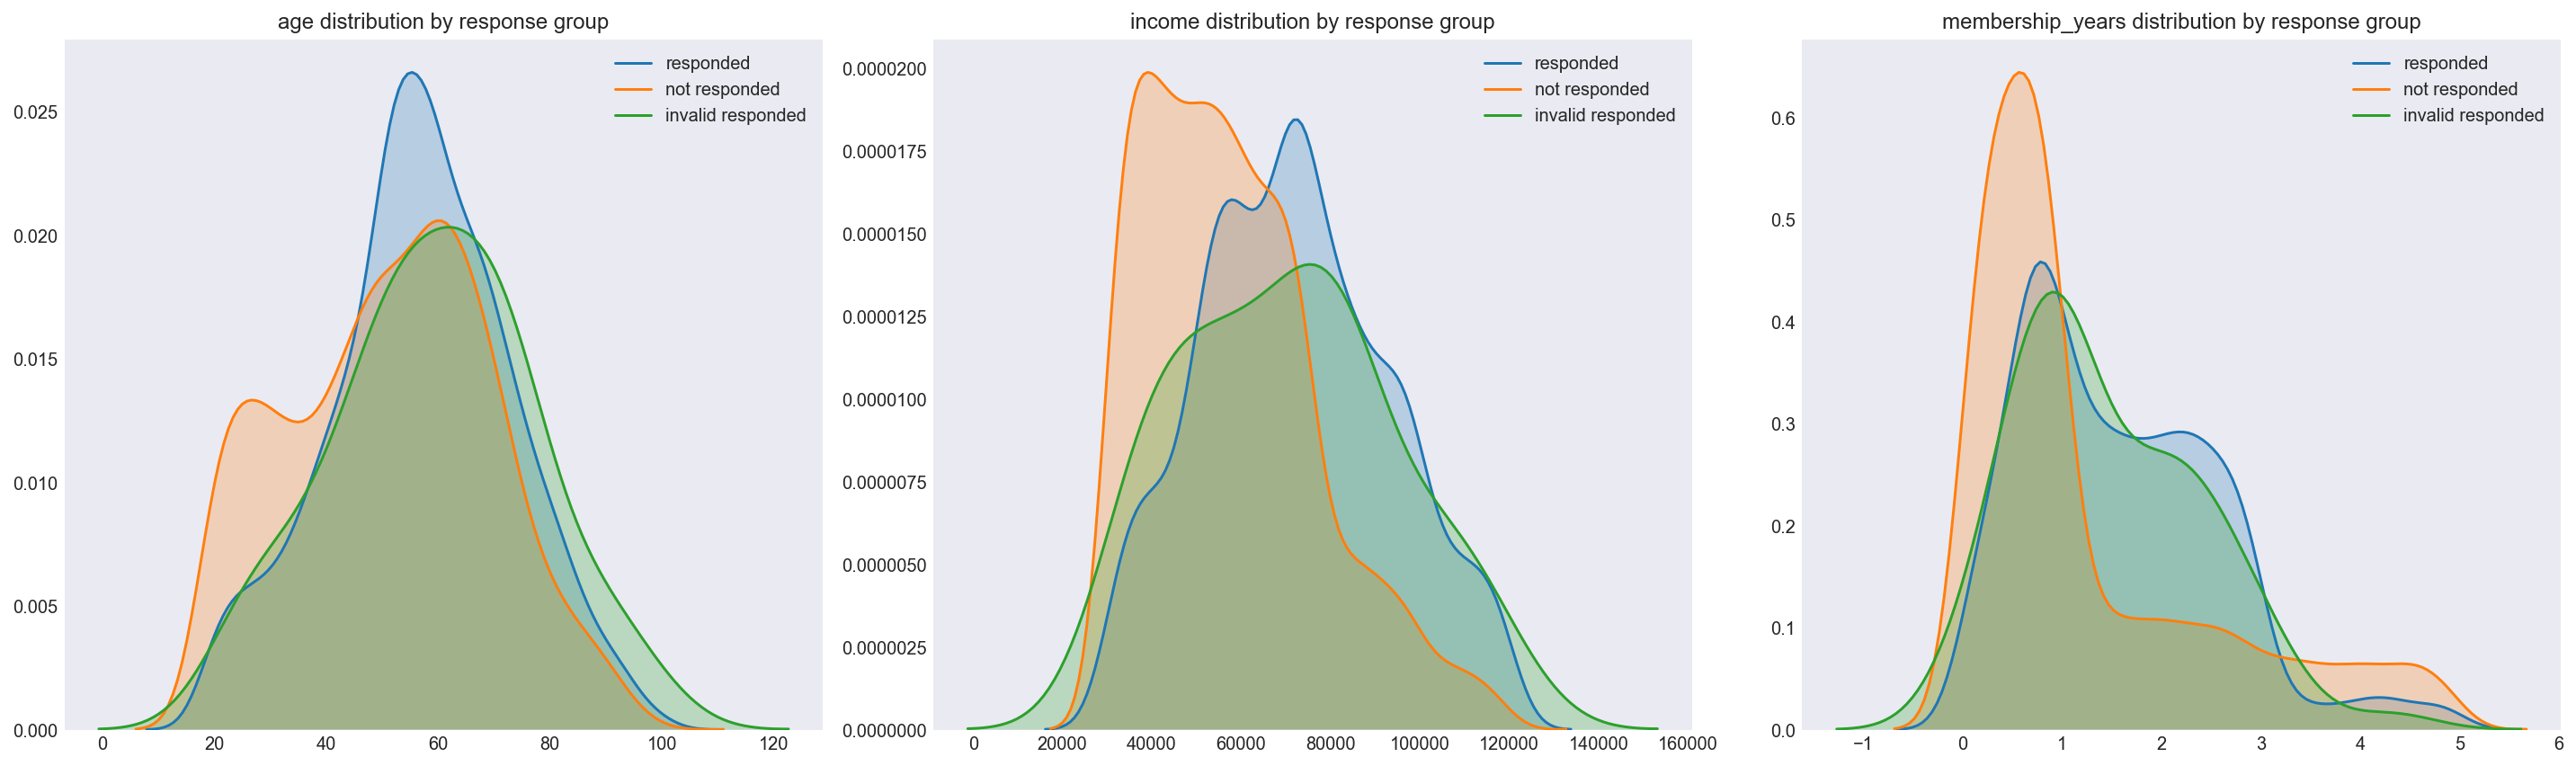

In [109]:
plot_compare_3_groups(create_offer_funnels('bogo_10_5_10_web_email_mobile_social'))

58.37 % responded
40.26 % did not respond
1.37 % invaildly responded


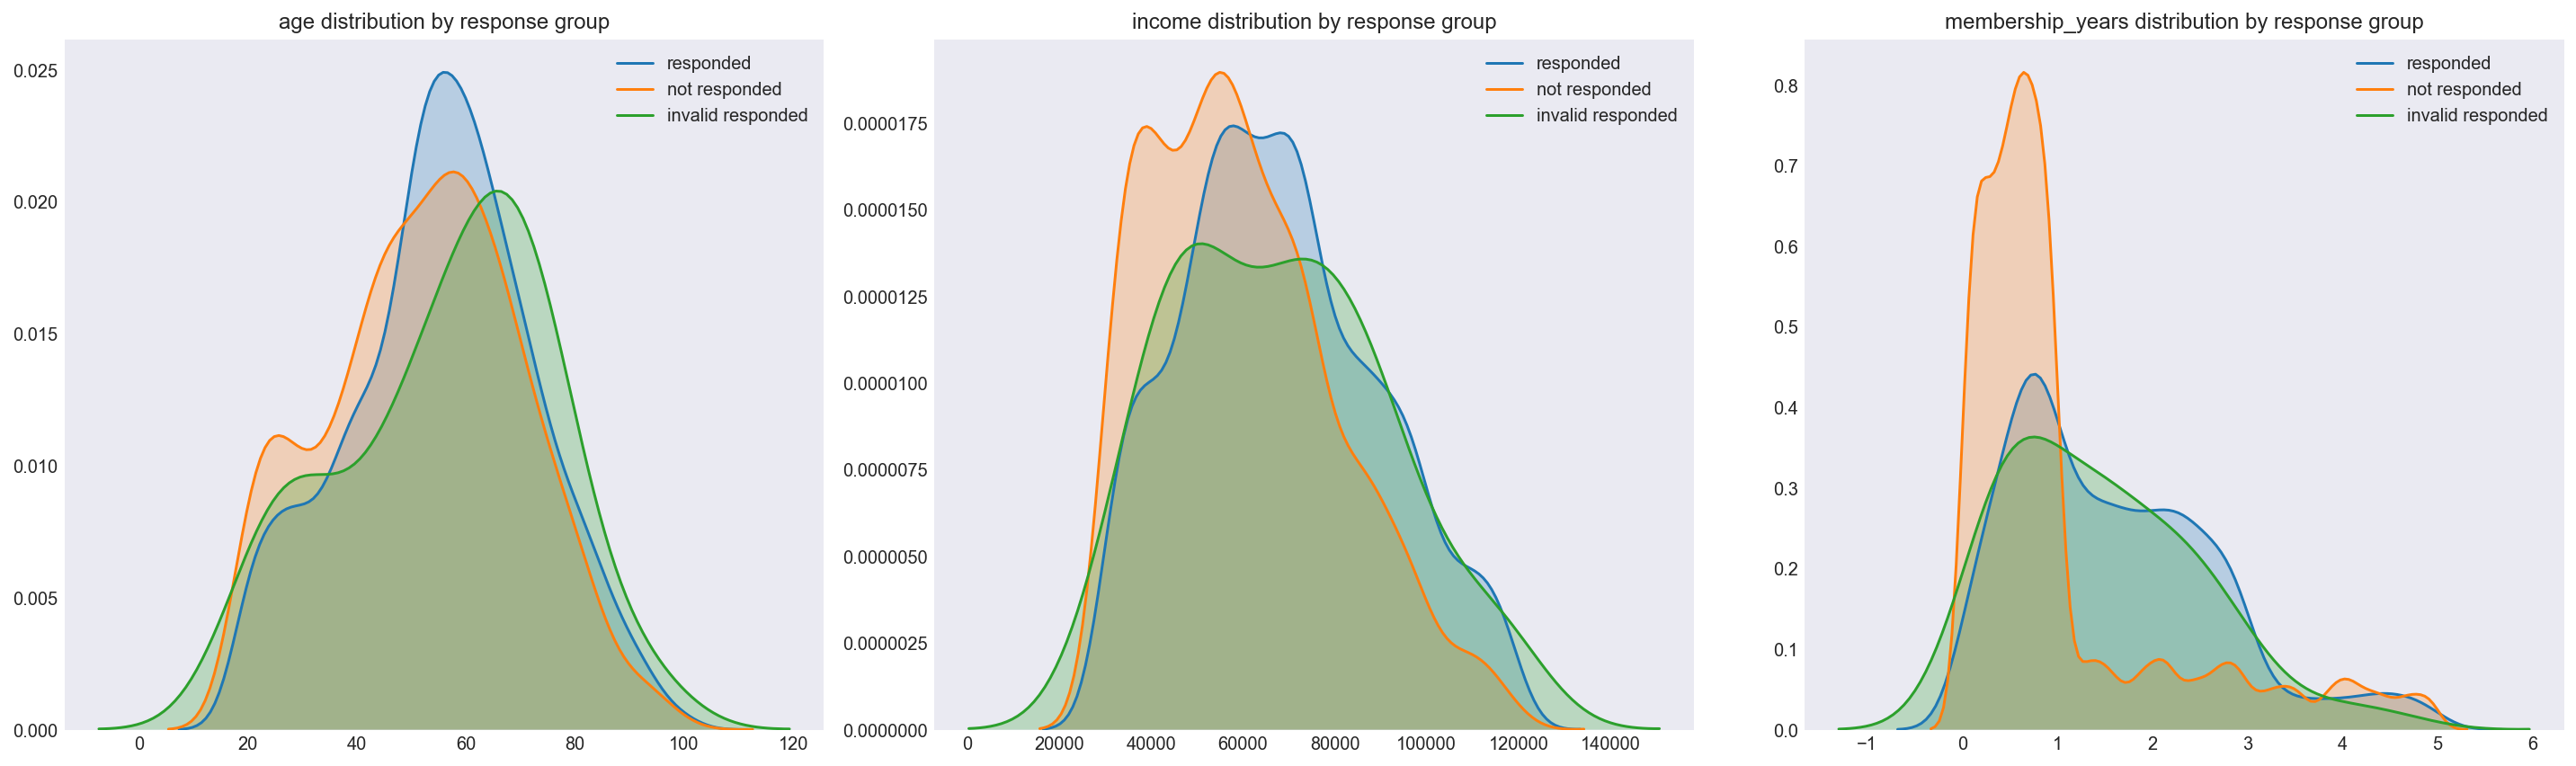

In [110]:
plot_compare_3_groups(create_offer_funnels('bogo_5_5_5_web_email_mobile_social'))

44.6 % responded
50.16 % did not respond
5.24 % invaildly responded


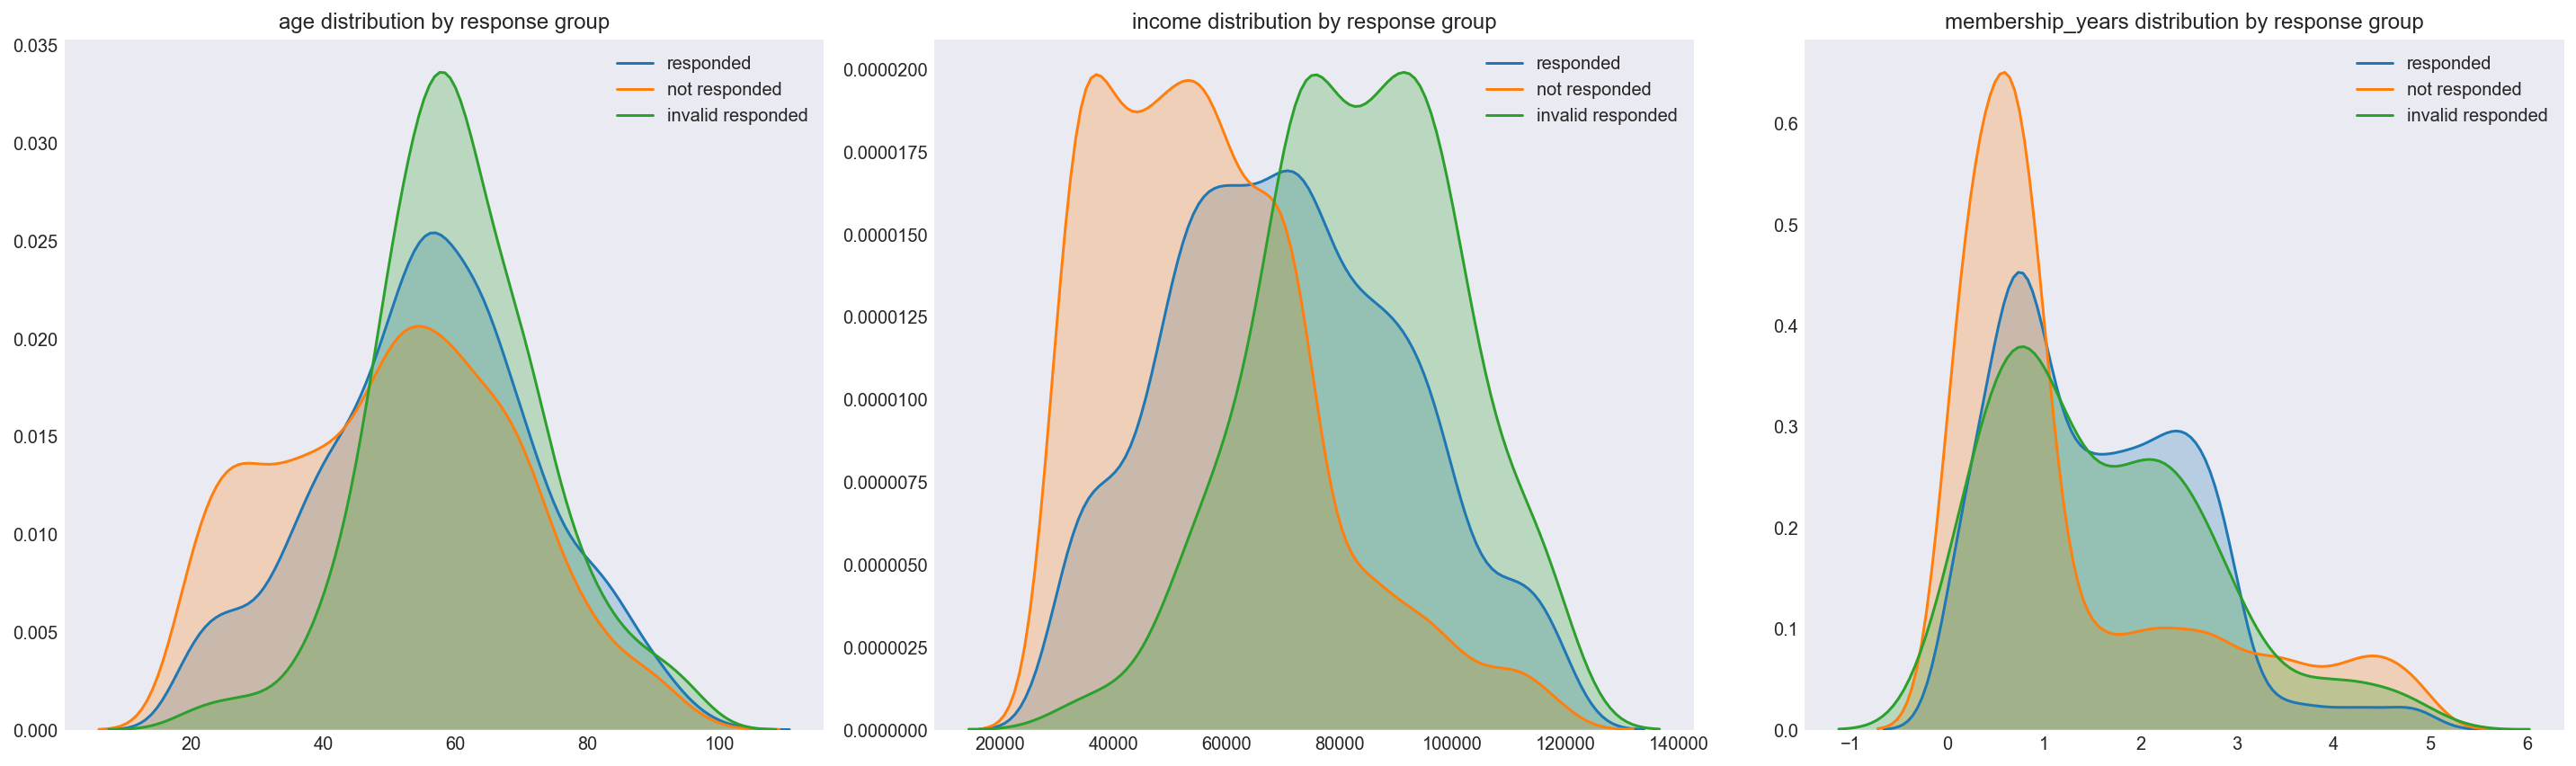

In [111]:
plot_compare_3_groups(create_offer_funnels('bogo_10_7_10_email_mobile_social'))

# Impute transactions and amount spent per week per customer
The reason why I chose weekly average as the metric is due to the nature of the test. This test is conducted for a month, while certain customers received their first offers from the first day, while some customers received their first offer at the end of the month. 

In [16]:
# left join weekly transactions to customers data
weekly_transactions = (transaction_events.groupby('customer_id').event.count()/4).to_frame().reset_index().rename({'event':'weekly_transactions'},axis=1)
customers = pd.merge(customers, weekly_transactions, how='left', left_on='id', right_on='customer_id')
customers.drop('customer_id',axis=1,inplace=True)
customers.head()

,gender,age,id,became_member_on,income,responded,not_responded,invalid_responded,membership_years,weekly_transactions
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,1,1.030137,0.75
1,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,1.213699,1.75
2,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1,0,0,0.249315,0.75
3,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1,0,0,0.457534,0.75
4,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1,0,0,0.704110,1.00


In [17]:
# Merge average weekly amount spent to customers dataset
weekly_amount_spent = (transaction_events.groupby('customer_id').amount_spent.sum()/4).to_frame().reset_index().rename({'amount_spent':'weekly_amount_spent'},axis=1)
customers = pd.merge(customers, weekly_amount_spent, how='left',left_on='id',right_on='customer_id')
customers.drop('customer_id',axis=1,inplace=True)
customers.fillna(0,inplace=True)
customers.head()

,gender,age,id,became_member_on,income,responded,not_responded,invalid_responded,membership_years,weekly_transactions,weekly_amount_spent
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,1,1.030137,0.75,19.2525
1,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,1.213699,1.75,39.8175
2,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1,0,0,0.249315,0.75,14.4325
3,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1,0,0,0.457534,0.75,9.1075
4,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1,0,0,0.704110,1.00,3.9050


### responded customers have higher weekly transactions and amount spent than those who didn't respond

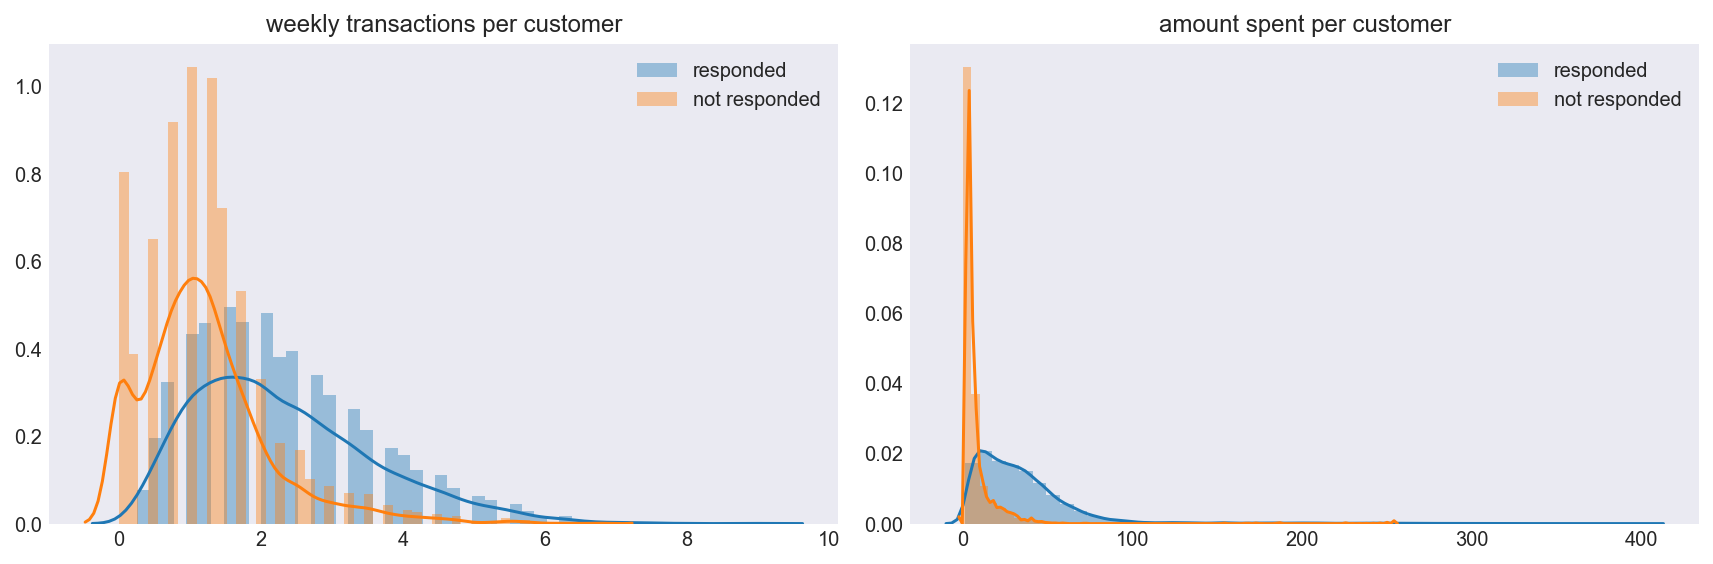

In [114]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(customers[customers.responded == 1].weekly_transactions,label='responded');
sns.distplot(customers[customers.responded == 0].weekly_transactions,label='not responded');
plt.legend(); plt.title('weekly transactions per customer'); plt.xlabel('');
plt.subplot(1,2,2)
sns.distplot(customers[customers.responded == 1].weekly_amount_spent,label='responded');
sns.distplot(customers[customers.responded == 0].weekly_amount_spent,label='not responded');
plt.legend(); plt.title('amount spent per customer'); plt.xlabel('');
plt.tight_layout()

In [22]:
customers = customers[customers.gender != 'O']

In [24]:
# customers.to_csv('cleaned_data/imputed_customers.csv',index=False)

# Build Machine Learning Model to classify customer response to offers

In [115]:
# Examine the ratios of target classes to decide on the classification metrics
print('valid response ratio:')
print(customers.responded.value_counts()/len(customers))

valid response ratio:
1    0.797031
0    0.202969
Name: responded, dtype: float64


In [117]:
# Split customers data into X and y
X = customers[['gender','age','income','membership_years','weekly_transactions','weekly_amount_spent']]

# Convert categorical features into dummy variables
X = pd.get_dummies(X)
X.drop('gender_O',axis=1,inplace=True)
X.head()

,age,income,membership_years,weekly_transactions,weekly_amount_spent,gender_F,gender_M
0,55.0,112000.0,1.030137,0.75,19.2525,1,0
1,75.0,100000.0,1.213699,1.75,39.8175,1,0
2,68.0,70000.0,0.249315,0.75,14.4325,0,1
3,65.0,53000.0,0.457534,0.75,9.1075,0,1
4,58.0,51000.0,0.704110,1.00,3.9050,0,1


## Plot ROC curve for model comparison
- We have 3 potential target variables to predict - responded, discount_responded, bogo_responded
- We already have good understandings of the 8 offers regarding response rates and demographics, we don't need to build a model for each offers as it could be biased due to the fact that not every customer received the same offer
- Depending on Starbuck's business objective, we can choose to predict whether the customer will respond to any offer at all; or predict whether the customer will respond to discount or bogo offers

In [118]:
def compare_roc(target):
    '''
    plot ROC for the given target variable - response/invalid response
    '''
    y = customers[target]
    # Set discount_response as the target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train three models
    log_reg = LogisticRegression().fit(X_train, y_train)
    rfc = RandomForestClassifier().fit(X_train, y_train)
    adaboost = AdaBoostClassifier().fit(X_train, y_train)

    # Plot ROC comparisons
    temp = plot_roc_curve(rfc, X_test, y_test)
    plot_roc_curve(adaboost, X_test, y_test, ax=temp.ax_)
    plot_roc_curve(log_reg, X_test, y_test, ax=temp.ax_)
    plt.title(f'ROC for {target}')

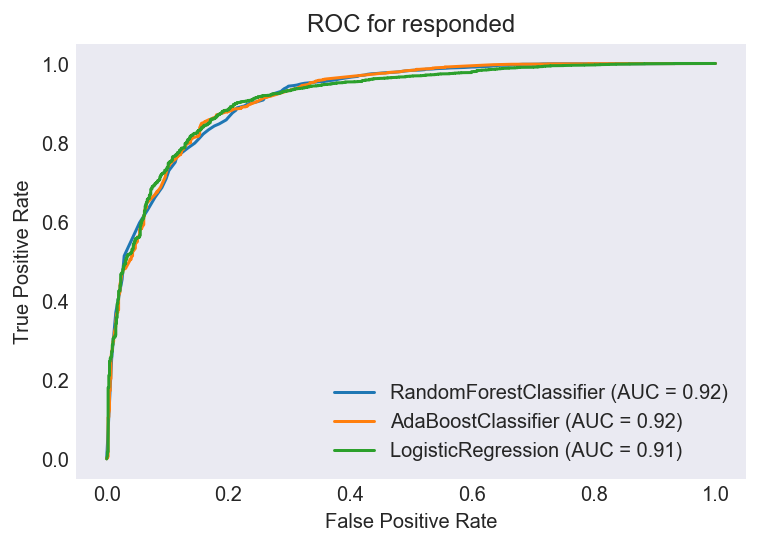

In [121]:
compare_roc('responded')

# Use GridSearchCV to find the best parameters for AdaBoost

In [122]:
# Set y as response
y = customers['responded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
}

model = GridSearchCV(AdaBoostClassifier(), param_grid=parameters, scoring='f1')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'best parameters: {model.best_params_}')
print(f'f1 score on the testset: {f1_score(y_test, y_pred)}')
print(f'accuracy on the testset: {accuracy_score(y_test, y_pred)}')

best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 50}
f1 score on the testset: 0.9387090205660761
accuracy on the testset: 0.8984480431848852


# Conclusion
After extensive EDA and data visualizations, I have come to the conclusion that the demographics for the 3 response groups have similar patterns regardless of offer_types:
- not_responded: customers with the lowest age, lowest income, and lowest days of membership
- invalid_responded: customers with the highest age, highest income, and highest days of membership
- responded: customers with age, income and days of membership in the middle, all slightly less than the invalid_responded group

Firstly, I analyzed demographics for 3 response groups from a macro level - all offers, and found out:
- 74.4 % customers responded to at least 1 offer
- 24.54 % customers did not respond to any offer
- 1.06 % customers completed all received offers without viewing them

Secondly, I analyzed demographics for 3 response groups for discount offers VS bogo offers, and found out:
- discount offers seems to have a slightly higher response rate than bogo offers (63% verses 59%)
- The demographics of discount and bogo response groups are quite similar

Thirdly, I analyzed demographics for 3 response groups for all 8 offers, and found out:
For discount offers:
- The discount offer people love the most is discount_10_10_2, with 70.1% response rate
- The discount offer people love the least is discount_20_10_5, with 23.09% response rate
- This may be due to the fact that the favorable offer has a lower barrier (10 dollars) whereas the least favorable offer has a high minimum spend (20 dollars)
- discount_10_7_2 has a 38% response rate whereas discount_10_10_2 has a 70.1% response rate, this may suggest that an 10-day expiration period gets much more responses than a 7-day expiration period
- In conclusion, people respond better to lower minimum spend and longer expiration days

For BOGO offers:
- The BOGO offer that people love the most is bogo_5_5_5, with a 58.37% response rate
- The BOGO offer that people love the least is bogo_5_7_5, with a 39.4% response rate
- It seems to be a different case for bogo offers, such that with the same conditions, a lower expiration period resulted in higher response rate

Lastly, I built an AdaBoost Machine Learning Model to predict customer response with a 0.92 ROC AUC, 0.94 F1 score and 0.90 accuracy. Because this is an open ended project, it was difficult for me to conclude on a business impact from this model, although it is high performing. Starbucks has many reasons to send out offers, such as promoting a new drink, boosting sales, increasing customer retention and loyalty, etc. If Starbucks wants to increase sales, sending out offers will certainly increase revenue, but not neccessarily profits, unless the promotion has an impact on sales after the promotions which will increase long term profit. 

But why do we bother to predict customer response instead of sending out offers to everyone? There are a number of reasons. First of all, not everyone responds positively to offers, some may dislike them, and it would be a better idea not to send them. Secondly, Starbucks wants to know which of the 8 offers can really excite people, so they can target the right customers with the right offers to ensure best response. Lastly, 1.06% of all customers in the dataset completed the offers without viewing them, which means that they would have spent the same amount of money without the offer. By not sending offers to those customers, Starbucks can save promotion costs associated with the offers. (we know that this 1.06% are people with highest income, highest age, and longest memberships)

# Improvements
This one-month experiment has its limitations. For example, not everyone received the same offers, so we don't know if a certain customer would have responded to another offer, should he/she receive it. Also, not everyone received their first offers at the same time. Although most customers received their first offer at the beginning of the experiment, there are 6 phases where Starbucks sent out first offers to customers. This means a few things: firstly, it is not fair to use offer completion rate as a metric, because every customer got a different number of offers throughout the experiment; secondly, weekly_transactions and weekly_amount_spent should be based on the assumption that all customers are in the same state (with offers or without offers), but the discrepancies in the data can make these 2 metrics biased and not reflect the actual purchasing behaviors of customers. 